# Data Tests notebook

`pytorch_datasets_playground.ipynb`

This notebook is for interactively developing tests for datasets and datamodules

Author: Jacob A Rose  
Created on: Tuesday May 4th, 2021

In [1]:
# from contrastive_learning.data.pytorch.pnas import PNASLightningDataModule
# from contrastive_learning.data.pytorch.extant import ExtantLightningDataModule
# from contrastive_learning.data.pytorch.fossil import Fossil


import logging

import logging
import os.path
 
def initialize_logger():
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
     
    # create console handler and set level to info
    handler = logging.StreamHandler()
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter("%(levelname)s - %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)

initialize_logger()
    
    
# from torchdata.datasets import Files
from more_itertools import flatten
from dataclasses import dataclass
from torchvision import transforms, models
import torchvision
import torchdata
import pandas as pd
from PIL import Image
from pathlib import Path
from typing import Dict, List, Optional, Callable, Sequence, Any, Union
import pytorch_lightning as pl
import torch
from contrastive_learning.data.pytorch.fossil import FossilDataset, FossilLightningDataModule

from pytorch_memlab import MemReporter


import collections
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np


from contrastive_learning.data.pytorch.common import (display_images,
                     filter_df_by_threshold,
                     plot_class_distributions,
                     plot_trainvaltest_splits)


from lightning_hydra_classifiers.models.transfer import TransferLearningModel

# import logging
# from functools import lru_cache
# from sklearn.model_selection import train_test_split

torch.backends.cudnn.benchmark = True

In [2]:
dataset_name = "Fossil_512"
size = 512
threshold = 3

# data = FossilDataset.create_dataset(name = dataset_name,
data = FossilDataset(name = dataset_name,
                     threshold = threshold)

transform = transforms.Compose([
                transforms.RandomResizedCrop(size=size,
                                             scale=(0.25, 1.2),
                                             ratio=(0.7, 1.3),
                                             interpolation=2),
                transforms.Grayscale(num_output_channels=3)
                              ])

data.transform = transform

In [3]:
threshold=3
test_split=0.3
val_train_split=0.2
batch_size=32
num_workers=0
seed=8567
debug=False
normalize=True
image_size = 'auto'
channels=3
dataset_dir=None
predict_on_split="val"

print(dataset_name)

Fossil_512


In [4]:
datamodule = FossilLightningDataModule(name=dataset_name,
                                       threshold=threshold,
                                       test_split=test_split,
                                       val_train_split=val_train_split,
                                       batch_size=batch_size,
                                       num_workers=num_workers,
                                       seed=seed,
                                       debug=debug,
                                       normalize=normalize,
                                       image_size=image_size,
                                       channels=channels,
                                       predict_on_split=predict_on_split)

datamodule

datamodule.setup("fit")
datamodule.setup("test")

# datamodule.show_batch("train")
# datamodule.show_batch("val")
# datamodule.show_batch("test")

INFO - stage=fit
INFO - Calling datamodule.setup(fit)
INFO - Retrieving the train split
INFO - Retrieving the val split
INFO - stage=test
INFO - Calling datamodule.setup(test)
INFO - Retrieving the test split


In [5]:
ckpt_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021/Fossil_512_train-test/2021-07-12/06-03/model/checkpoints/"
ckpt_path = os.path.join(ckpt_dir, "best_model-epoch-epoch=05--val_loss-val_loss=96.52.ckpt")

print(os.path.isfile(ckpt_path))

True


In [7]:
ckpt_state = torch.load(ckpt_path)

print(type(ckpt_state))

<class 'dict'>


In [12]:
print(ckpt_state.keys())

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'optimizer_states', 'lr_schedulers', 'native_amp_scaling_state'])


In [14]:
pl.__version__

'1.3.7'

In [11]:
print(ckpt_state['state_dict'].keys())

odict_keys(['classifier.backbone.conv1.weight', 'classifier.backbone.bn1.weight', 'classifier.backbone.bn1.bias', 'classifier.backbone.bn1.running_mean', 'classifier.backbone.bn1.running_var', 'classifier.backbone.bn1.num_batches_tracked', 'classifier.backbone.layer1.0.conv1.weight', 'classifier.backbone.layer1.0.bn1.weight', 'classifier.backbone.layer1.0.bn1.bias', 'classifier.backbone.layer1.0.bn1.running_mean', 'classifier.backbone.layer1.0.bn1.running_var', 'classifier.backbone.layer1.0.bn1.num_batches_tracked', 'classifier.backbone.layer1.0.conv2.weight', 'classifier.backbone.layer1.0.bn2.weight', 'classifier.backbone.layer1.0.bn2.bias', 'classifier.backbone.layer1.0.bn2.running_mean', 'classifier.backbone.layer1.0.bn2.running_var', 'classifier.backbone.layer1.0.bn2.num_batches_tracked', 'classifier.backbone.layer1.0.conv3.weight', 'classifier.backbone.layer1.0.bn3.weight', 'classifier.backbone.layer1.0.bn3.bias', 'classifier.backbone.layer1.0.bn3.running_mean', 'classifier.backbo

In [6]:
model = TransferLearningModel.load_from_checkpoint(ckpt_path)

TypeError: __init__() missing 1 required positional argument: 'classifier'

In [ ]:
train_data, val_data, test_data = data.create_trainvaltest_splits(dataset=data,
                                                                  test_split=0.3,
                                                                  val_train_split=0.2,
                                                                  shuffle=True,
                                                                  seed=3654,
                                                                  plot_distributions=True)

In [21]:

config_dir = "/media/data/jacob/GitHub/lightning-hydra-classifiers/configs"

from hydra.experimental import compose, initialize, initialize_config_dir
from omegaconf import OmegaConf
import os
from rich import print as pp
os.chdir(config_dir)

# context initialization
# with initialize(config_path="../configs", job_name="test_app"):

with initialize_config_dir(config_dir=config_dir, job_name="multi-gpu_experiment"):
    
    cfg = compose(config_name="multi-gpu")
#     print(OmegaConf.to_yaml(cfg))
    
    pp(OmegaConf.to_container(cfg, resolve=True))
    
    pp(os.environ)

{
    'trainer': {
        '_target_': 'pytorch_lightning.Trainer',
        'gpus': [0, 1],
        'auto_select_gpus': True,
        'min_epochs': 1,
        'max_epochs': 40,
        'weights_summary': 'top',
        'progress_bar_refresh_rate': 10,
        'profiler': 'simple',
        'log_every_n_steps': 50,
        'terminate_on_nan': False,
        'fast_dev_run': False,
        'limit_train_batches': 1.0,
        'limit_val_batches': 1.0,
        'accelerator': 'ddp',
        'amp_backend': 'native',
        'amp_level': '02',
        'precision': 16
    },
    'model': {
        '_target_': 'lightning_hydra_classifiers.models.transfer.TransferLearningModel',
        'classifier': {
            '_target_': 'lightning_hydra_classifiers.models.transfer.Classifier',
            'backbone_name': 'resnet50',
            'num_classes': None,
            'finetune': True
        },
        'train_bn': False,
        'milestones': [5, 10],
        'batch_size': 128,
        'optimizer': 'Adam',
        'lr': 0.002,
        'lr_scheduler_gamma': 0.1,
        'model_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-
Nov2021/Fossil_512_train-test/2021-07-12/03-32/model'
    },
    'datamodule': {
        '_target_': 'contrastive_learning.data.pytorch.fossil.FossilLightningDataModule',
        'name': 'Fossil_512',
        'val_train_split': 0.2,
        'test_split': 0.3,
        'threshold': 3,
        'batch_size': 128,
        'seed': 95893,
        'num_workers': 0,
        'normalize': True,
        'num_classes': None,
        'image_size': 512,
        'color_mode': 'grayscale',
        'channels': 3,
        'class_type': 'family',
        'predict_on_split': 'val',
        'debug': False,
        'kwargs': {'basename': 'Fossil'}
    },
    'callbacks': {
        'finetuning': {
            '_target_': 'lightning_hydra_classifiers.models.transfer.MilestonesFinetuning',
            'milestones': [5, 10],
            'train_bn': False
        },
        'checkpoint': {
            '_target_': 'pytorch_lightning.callbacks.ModelCheckpoint',
            'monitor': 'val/loss',
            'dirpath': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July202
1-Nov2021/Fossil_512_train-test/2021-07-12/03-32/model/checkpoints',
            'filename': 'best_model-epoch-{epoch:02d}--val_loss-{val_loss:.2f}',
            'save_top_k': 2,
            'mode': 'min'
        },
        'uploadaheckpointsasartifact': {
            '_target_': 
'lightning_hydra_classifiers.utils.logging_utils.UploadCheckpointsAsArtifact',
            'ckpt_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July20
21-Nov2021/Fossil_512_train-test/2021-07-12/03-32/model/checkpoints',
            'upload_best_only': False
        },
        'logconfusionmatrix': {
            '_target_': 'lightning_hydra_classifiers.utils.logging_utils.LogConfusionMatrix',
            'class_names': None
        },
        'log_per_class_metrics_to_wandb': {
            '_target_': 
'lightning_hydra_classifiers.callbacks.wandb_callbacks.LogPerClassMetricsToWandb'
        },
        'module_data_monitor': {'_target_': 'pl_bolts.callbacks.ModuleDataMonitor'}
    },
    'logger': {
        'wandb': {
            '_target_': 'pytorch_lightning.loggers.wandb.WandbLogger',
            'entity': 'jrose',
            'project': 'image_classification',
            'job_type': 'train',
            'group': 'stage_0'
        },
        'csv': {
            '_target_': 'pytorch_lightning.loggers.csv_logs.CSVLogger',
            'save_dir': '/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July20
21-Nov2021/Fossil_512_train-test/2021-07-12/03-32/model/results/logs',
            'name': 'csv/'
        }
    },
    'job_type': 'Fossil_512_train-test',
    'root_dir': '/media/data/jacob/wandb_cache',
    'work_dir': 
'/media/data_cifs/projects/prj_fossils/users/jacob/experiments/July2021-Nov2021',
    'job_dir': '/media/

environ({
    'MANPATH': ':/opt/puppetlabs/puppet/share/man',
    'XDG_SESSION_ID': '6',
    'VIRTUALENVWRAPPER_SCRIPT': '/usr/share/virtualenvwrapper/virtualenvwrapper.sh',
    'TERM': 'xterm-color',
    'SHELL': '/bin/bash',
    'WANDB_PROJECT': 'default',
    'SSH_CLIENT': '10.55.137.104 61825 22',
    'CONDA_SHLVL': '2',
    'CONDA_PROMPT_MODIFIER': '(sequoia) ',
    'OLDPWD': '/home/jrose3/dotfiles',
    'SSH_TTY': '/dev/pts/8',
    'USER': 'jrose3',
    'LS_COLORS': 'rs=0:di=01;34:ln=01;36:mh=00:pi=40;33:so=01;35:do=01;35:bd=40;33;01:cd=40;3
3;01:or=40;31;01:mi=00:su=37;41:sg=30;43:ca=30;41:tw=30;42:ow=34;42:st=37;44:ex=01;32:*.tar=0
1;31:*.tgz=01;31:*.arc=01;31:*.arj=01;31:*.taz=01;31:*.lha=01;31:*.lz4=01;31:*.lzh=01;31:*.lz
ma=01;31:*.tlz=01;31:*.txz=01;31:*.tzo=01;31:*.t7z=01;31:*.zip=01;31:*.z=01;31:*.Z=01;31:*.dz
=01;31:*.gz=01;31:*.lrz=01;31:*.lz=01;31:*.lzo=01;31:*.xz=01;31:*.bz2=01;31:*.bz=01;31:*.tbz=
01;31:*.tbz2=01;31:*.tz=01;31:*.deb=01;31:*.rpm=01;31:*.jar=01;31:*.war=01;31:*.ear=01;31:*.s
ar=01;31:*.rar=01;31:*.alz=01;31:*.ace=01;31:*.zoo=01;31:*.cpio=01;31:*.7z=01;31:*.rz=01;31:*
.cab=01;31:*.jpg=01;35:*.jpeg=01;35:*.gif=01;35:*.bmp=01;35:*.pbm=01;35:*.pgm=01;35:*.ppm=01;
35:*.tga=01;35:*.xbm=01;35:*.xpm=01;35:*.tif=01;35:*.tiff=01;35:*.png=01;35:*.svg=01;35:*.svg
z=01;35:*.mng=01;35:*.pcx=01;35:*.mov=01;35:*.mpg=01;35:*.mpeg=01;35:*.m2v=01;35:*.mkv=01;35:
*.webm=01;35:*.ogm=01;35:*.mp4=01;35:*.m4v=01;35:*.mp4v=01;35:*.vob=01;35:*.qt=01;35:*.nuv=01
;35:*.wmv=01;35:*.asf=01;35:*.rm=01;35:*.rmvb=01;35:*.flc=01;35:*.avi=01;35:*.fli=01;35:*.flv
=01;35:*.gl=01;35:*.dl=01;35:*.xcf=01;35:*.xwd=01;35:*.yuv=01;35:*.cgm=01;35:*.emf=01;35:*.og
v=01;35:*.ogx=01;35:*.aac=00;36:*.au=00;36:*.flac=00;36:*.m4a=00;36:*.mid=00;36:*.midi=00;36:
*.mka=00;36:*.mp3=00;36:*.mpc=00;36:*.ogg=00;36:*.ra=00;36:*.wav=00;36:*.oga=00;36:*.opus=00;
36:*.spx=00;36:*.xspf=00;36:',
    'CONDA_EXE': '/media/data/anaconda/bin/conda',
    'TMUX': '/tmp/tmux-140140405/default,4678,0',
    'WANDB_ENTITY': 'jrose',
    '_CE_CONDA': '',
    'CONDA_PREFIX_1': '/media/data/anaconda',
    'PATH': '/usr/local/cuda-10.1/bin:/usr/local/cuda-8.0/bin:/opt/singularity/bin:/media/dat
a/conda/jrose3/envs/sequoia/bin:/media/data/anaconda/condabin:/usr/local/cuda-10.1/bin:/usr/l
ocal/cuda-8.0/bin:/opt/singularity/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbi
n:/bin:/usr/games:/usr/local/games:/snap/bin:/opt/puppetlabs/bin:/home/jrose3/.local/bin:/hom
e/jrose3/.globus-cli-virtualenv/bin:/home/jrose3/.local/bin:/home/jrose3/.globus-cli-virtuale
nv/bin',
    'MAIL': '/var/mail/jrose3',
    'CONDA_ENVS_DIRS': '/media/data/conda/jrose3/envs',
    'CONDA_PREFIX': '/media/data/conda/jrose3/envs/sequoia',
    'EVENT_NOEPOLL': '1',
    'PWD': '/',
    'CONDA_PKGS_DIRS': '/media/data/conda/pkgs',
    'LANG': 'en_US.UTF-8',
    'TMUX_PANE': '%2',
    '_CE_M': '',
    'KRB5CCNAME': 'FILE:/tmp/krb5cc_140140405_08MBeo',
    'TORCH_HOME': '/media/data/jacob/pretrained_model_weights/torch',
    'HOME': '/home/jrose3',
    'SHLVL': '2',
    'TERMINFO': '/usr/share/terminfo/',
    'TOY_DATA_DIR': '/media/data_cifs/projects/prj_fossils/data/toy_data',
    '_VIRTUALENVWRAPPER_API': ' mkvirtualenv rmvirtualenv lsvirtualenv showvirtualenv workon 
add2virtualenv cdsitepackages cdvirtualenv lssitepackages toggleglobalsitepackages 
cpvirtualenv setvirtualenvproject mkproject cdproject mktmpenv mkvirtualenv rmvirtualenv 
lsvirtualenv showvirtualenv workon add2virtualenv cdsitepackages cdvirtualenv lssitepackages 
toggleglobalsitepackages cpvirtualenv setvirtualenvproject mkproject cdproject mktmpenv 
mkvirtualenv rmvirtualenv lsvirtualenv showvirtualenv workon add2virtualenv cdsitepackages 
cdvirtualenv lssitepackages toggleglobalsitepackages cpvirtualenv setvirtualenvproject 
mkproject cdproject mktmpenv mkvirtualenv rmvirtualenv lsvirtualenv showvirtualenv workon 
add2virtualenv cdsitepackages cdvirtualenv lssitepackages toggleglobalsitepackages 
cpvirtualenv setvirtuale

In [5]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [6]:

sns_context = "talk"
sns_style = "seaborn-bright"
sns.set_context(context=sns_context, font_scale=0.8)
# valid contexts = paper, notebook, talk, poster - 
# with notebook being 1:1 and paper being smaller and poster being largest
plt.style.use(sns_style)



In [8]:
# def plot_class_distributions(targets: List[Any], 
#                              sort: Union[bool,Sequence]=True,
#                              ax=None,
#                              xticklabels: bool=True):
#     """
#     Example:
#         counts = plot_class_distributions(targets=data.targets, sort=True)
#     """
#     counts = collections.Counter(targets)
#     if hasattr(sort, "__len__"):
#         counts = {k: counts[k] for k in sort}
#     elif sort is True:
#         counts = dict(sorted(counts.items(), key = lambda x:x[1], reverse=True))

#     keys = list(counts.keys())
#     values = list(counts.values())

#     if ax is None:
#         plt.figure(figsize=(16,12))
#     ax = sns.histplot(x=keys, weights=values, discrete=True, ax=ax)
#     plt.sca(ax)
#     if xticklabels:
#         plt.xticks(
#             rotation=45, 
#             horizontalalignment='right',
#             fontweight='light',
#             fontsize='medium'
#         )
#     else:
#         ax.set_xticklabels([])
    
#     return counts


# def plot_trainvaltest_splits(train_data,
#                              val_data,
#                              test_data):
#     """
#     Create 3 vertically-stacked count plots of train, val, and test dataset class label distributions
#     """
#     fig, ax = plt.subplots(3, 1, figsize=(16,8*3))

#     train_counts = plot_class_distributions(targets=train_data.targets, sort=True, ax = ax[0], xticklabels=False)
#     plt.gca().set_title(f"train (n={len(train_data)})", fontsize='large')
#     sort_classes = train_counts.keys()

#     val_counts = plot_class_distributions(targets=val_data.targets, ax = ax[1], sort=sort_classes, xticklabels=False)
#     plt.gca().set_title(f"val (n={len(val_data)})", fontsize='large')
#     test_counts = plot_class_distributions(targets=test_data.targets, ax = ax[2], sort=sort_classes)
#     plt.gca().set_title(f"test (n={len(test_data)})", fontsize='large')

#     plt.suptitle(f"Train-Val-Test_splits (total={len(data)})", fontsize='x-large')

#     plt.subplots_adjust(bottom=0.1, top=0.95, wspace=None, hspace=0.07)
    
#     return fig, ax



NameError: name 'data' is not defined

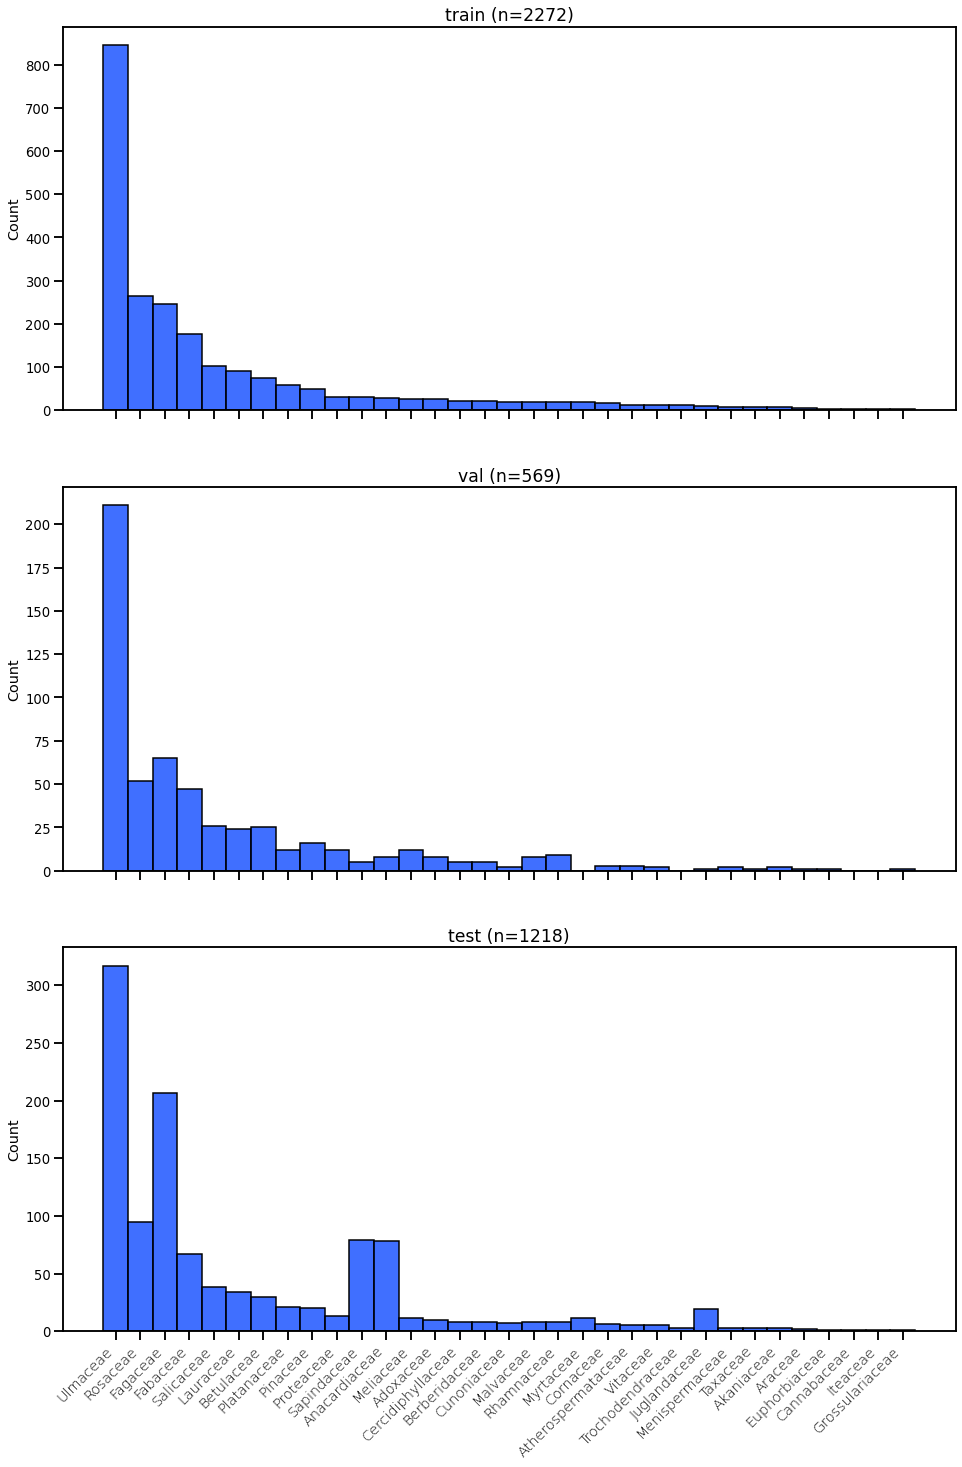

In [9]:
plot_trainvaltest_splits(train_data,
                         val_data,
                         test_data)

# End

In [24]:
train_data = select_from_dataset(data,
                                 indices=train_idx,
                                 update_class2idx=False,
                                 x_col = 'path',
                                 y_col = "family")

val_data = select_from_dataset(data,
                               indices=val_idx,
                               update_class2idx=False,
                               x_col = 'path',
                               y_col = "family")
val_data

test_data = select_from_dataset(data,
                                indices=test_idx,
                                update_class2idx=False,
                                x_col = 'path',
                                y_col = "family")



train_counts = plot_class_distributions(targets=train_data.targets, sort=True)
sort_classes = train_counts.keys()
val_counts = plot_class_distributions(targets=val_data.targets, sort=sort_classes)
test_counts = plot_class_distributions(targets=test_data.targets, sort=sort_classes)


train_data = (train_val_samples)
train_samples = np.array(train_val_samples)[train_idx]
val_samples = np.array(train_val_samples)[val_idx]


counts = plot_class_distributions(targets=data.targets, sort=True)

train_val_idx.shape
test_idx.shape

In [ ]:
class DataSplit:

    def __init__(self,
                 dataset,
                 test_split=0.3,
                 val_train_split=0.2,
                 shuffle: bool=False,
                 seed: int=None):
        
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = np.arange(range(dataset_size))
#         test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        targets = dataset.targets

        train_val_idx, test_idx = train_test_split(
                                               indices,
                                               test_size=test_split,
                                               random_state=seed,
                                               shuffle=shuffle,
                                               stratify=targets)
        
            
            
        train_indices, self.test_indices = self.indices[], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[ : validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)

    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=4):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing train dataloader')
        self.train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing validation dataloader')
        self.val_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=4):
        logging.debug('Initializing test dataloader')
        self.test_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

In [ ]:
df = pd.DataFrame(data.samples)#.iloc[:,0]
df = df.assign(sub_dataset = df.apply(lambda x: x[0].parts[-3], axis=1)) #.value_counts()

df = df.rename(columns={0:"path",
                        1:"family",
                        2:"genus",
                        3:"species",
                        4:"collection",
                        5:"catalog_number"})#.value_counts()



In [7]:
from sklearn.model_selection import train_test_split

targets = dataset.targets

train_idx, valid_idx = train_test_split(
                                        indices,
                                        test_size=test_split,
                                        random_state=seed,
                                        shuffle=True,
                                        stratify=targets)

print(np.unique(np.array(targets)[train_idx], return_counts=True))
print(np.unique(np.array(targets)[valid_idx], return_counts=True))


# val_split = 0.2
# test_split = 0.3
# total = 1.0
# trainval_split = total-test_split
# print(trainval_split)
# print(trainval_split - val_split)
# print((val_split/(trainval_split)))# - val_split)

(val_split*0.7)# + 0.7

In [7]:
# class FossilDatasetSubset(FossilDataset):
    
#     def __init__(self,
#                  split
#                  files: List[Path]=None,
#                  name: Optional[str]=None,
#                  return_items: List[str] = ["image","target","path"],
#                  image_return_type: str = "tensor",
#                  *args, **kwargs):
#                 ):

In [4]:
print('starting')

model = models.resnet18()
# inputs = torch.randn(5, 3, 224, 224)


10


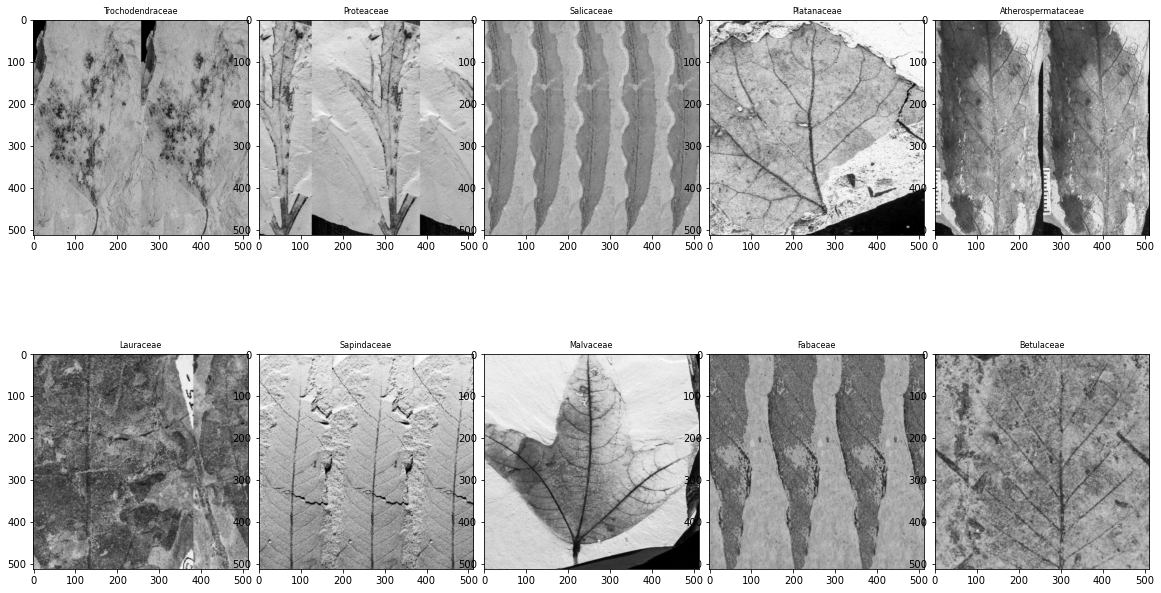

In [6]:
from torch.utils.data import DataLoader
from torch import nn
batch_size = 64

dataloader = DataLoader(data,
                        batch_size=batch_size,
                        shuffle=False)
#                         sampler=None,
#                         batch_sampler=None,
#                         num_workers=0,
#                         collate_fn=None,
#                         pin_memory=False,
#                         drop_last=False,
#                         timeout=0,
#                         worker_init_fn=None)

# idx = [0,10,20,50,100]
# idx = 10
idx = list(range(0,1000,100))
print(len(idx))
data.display_grid(idx, repeat_n=1)


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# data.samples[0][0].parts[-3]

df = pd.DataFrame(data.samples)#.iloc[:,0]
df = df.assign(sub_dataset = df.apply(lambda x: x[0].parts[-3], axis=1)) #.value_counts()

df = df.rename(columns={0:"path",
                        1:"family",
                        2:"genus",
                        3:"species",
                        4:"collection",
                        5:"catalog_number"})#.value_counts()

# df.value_counts().plot(kind='bar')

chart = sns.catplot(
    data=df, #[data['Year'].isin([1980, 2008])],
    x='family',
    kind='count',
    palette='Set1',
    row='sub_dataset',
    aspect=3,
    height=3
)
chart.set_xticklabels(rotation=65, horizontalalignment='right')

In [18]:
by_sport = (df
            .groupby('family')
            .filter(lambda x : len(x) > 10)
            .groupby(['family', 'genus'])
#             .groupby(['genus', 'species'])
            .size()
            .unstack()
           )
by_sport

genus               "Ficus"  Acer  Aesculus  Allophylus  Alnus  Amelanchier  \
family                                                                        
Adoxaceae               NaN   NaN       NaN         NaN    NaN          NaN   
Anacardiaceae           NaN   NaN       NaN         NaN    NaN          NaN   
Atherospermataceae      NaN   NaN       NaN         NaN    NaN          NaN   
Berberidaceae           NaN   NaN       NaN         NaN    NaN          NaN   
Betulaceae              NaN   NaN       NaN         NaN   34.0          NaN   
Cercidiphyllaceae       NaN   NaN       NaN         NaN    NaN          NaN   
Cornaceae               NaN   NaN       NaN         NaN    NaN          NaN   
Cunoniaceae             NaN   NaN       NaN         NaN    NaN          NaN   
Cupressaceae            NaN   NaN       NaN         NaN    NaN          NaN   
Dryopteridaceae         NaN   NaN       NaN         NaN    NaN          NaN   
Fabaceae                NaN   NaN       NaN         NaN    NaN          NaN   
Fagaceae                NaN   NaN       NaN         NaN    NaN          NaN   
Juglandaceae            NaN   NaN       NaN         NaN    NaN          NaN   
Lauraceae               1.0   NaN       NaN         NaN    NaN          NaN   
Malvaceae               NaN   NaN       NaN         NaN    NaN          NaN   
Meliaceae               NaN   NaN       NaN         NaN    NaN          NaN   
Myrtaceae               NaN   NaN       NaN         NaN    NaN          NaN   
Pinaceae                NaN   NaN       NaN         NaN    NaN          NaN   
Platanaceae             NaN   NaN       NaN         NaN    NaN          NaN   
Proteaceae              NaN   NaN       NaN         NaN    NaN          NaN   
Rhamnaceae              NaN   NaN       NaN         NaN    NaN          NaN   
Rosaceae                NaN   NaN       NaN         NaN    NaN         10.0   
Salicaceae              NaN   NaN       NaN         NaN    NaN          NaN   
Sapindaceae             NaN  36.0       3.0        10.0    NaN          NaN   
Trochodendraceae        NaN   NaN       NaN         NaN    NaN          NaN   
Ulmaceae                NaN   NaN       NaN         NaN    NaN          NaN   
Vitaceae                NaN   NaN       NaN         NaN    NaN          NaN   

genus               Anacardiaceae  Archeampelos  Atherospermophyllum  Athyana  \
family                                                                          
Adoxaceae                     NaN           NaN                  NaN      NaN   
Anacardiaceae                 5.0           NaN                  NaN      NaN   
Atherospermataceae            NaN           NaN                 16.0      NaN   
Berberidaceae                 NaN           NaN                  NaN      NaN   
Betulaceae                    NaN           NaN                  NaN      NaN   
Cercidiphyllaceae             NaN           2.0                  NaN      NaN   
Cornaceae                     NaN           NaN                  NaN      NaN   
Cunoniaceae                   NaN           NaN                  NaN      NaN   
Cupressaceae                  NaN           NaN                  NaN      NaN   
Dryopteridaceae               NaN           NaN                  NaN      NaN   
Fabaceae                      NaN           NaN                  NaN      NaN   
Fagaceae                      NaN           NaN                  NaN      NaN   
Juglandaceae                  NaN           NaN                  NaN      NaN   
Lauraceae                     NaN           NaN                  NaN      NaN   
Malvaceae                     NaN           NaN                  NaN      NaN   
Meliaceae                     NaN           NaN                  NaN      NaN   
Myrtaceae                     NaN           NaN                  NaN      NaN   
Pinaceae                      NaN           NaN                  NaN      NaN   
Platanaceae                   NaN           NaN                  NaN      NaN   
Proteac

In [9]:
# def select_from_indices(data,
#                         indices: Sequence,
#                         update_class2idx: bool=False,
#                         x_col = 'path',
#                         y_col = "family") -> "FossilDataset":
#     """
#     Helper method to create a new FossilDataset containing only samples contained in `indices`
#     Useful for producing train/val/test splits
    
#     """
#     if update_class2idx:
#         class2idx=None
#     else:
#         class2idx=data.class2idx

    
#     df = pd.DataFrame(data.samples)
#     df = df.rename(columns={0:"path",
#                             1:"family",
#                             2:"genus",
#                             3:"species",
#                             4:"collection",
#                             5:"catalog_number"})#.value_counts()
    
#     df = df.iloc[indices,:]
    
#     files = df[x_col].to_list()

#     return FossilDataset(files=files,
#                          name=data.name,
#                          return_items=data.return_items,
#                          image_return_type=data.image_return_type,
#                          class2idx=class2idx)



# def filter_df_by_threshold(df: pd.DataFrame,
#                            threshold: int,
#                            y_col: str='family'):
#     """
#     Filter rare classes from dataset in a pd.DataFrame
    
#     Input:
#         df (pd.DataFrame):
#             Must contain at least 1 column with name given by `y_col`
#         threshold (int):
#             Exclude any rows from df that contain a `y_col` value with fewer than `threshold` members in all of df.
#         y_col (str): default="family"
#             The column in df to look for rare classes to exclude.
#     Output:
#         (pd.DataFrame):
#             Returns a dataframe with the same number of columns as df, and an equal or lower number of rows.
#     """
#     return df.groupby(y_col).filter(lambda x: len(x) >= threshold)



# def filter_samples_by_threshold(data: FossilDataset,
#                                 threshold: int=1,
#                                 update_class2idx: bool=True,
#                                 x_col = 'path',
#                                 y_col = "family") -> FossilDataset:
#     if update_class2idx:
#         class2idx=None
#     else:
#         class2idx=data.class2idx

        
#     df = pd.DataFrame(data.samples)
#     df = df.rename(columns={0:"path",
#                             1:"family",
#                             2:"genus",
#                             3:"species",
#                             4:"collection",
#                             5:"catalog_number"})#.value_counts()
    
#     df = filter_df_by_threshold(df=df,
#                                 threshold=threshold,
#                                 y_col=y_col)
        
#     files = df[x_col].to_list()

#     return FossilDataset(files=files,
#                          name=data.name,
#                          return_items=data.return_items,
#                          image_return_type=data.image_return_type,
#                          class2idx=class2idx)


In [10]:
# # dataset.targets

# @classmethod
# def create_trainvaltest_splits(cls,
#                                dataset,
#                                test_split: float=0.3,
#                                val_train_split: float=0.2,
#                                shuffle: bool=True,
#                                seed: int=3654):

#     dataset_size = len(dataset)
#     indices = np.arange(dataset_size)

#     samples = np.array(dataset.samples)
#     targets = np.array(dataset.targets)

#     train_val_idx, test_idx = train_test_split(
#                                                indices,
#                                                test_size=test_split,
#                                                random_state=seed,
#                                                shuffle=shuffle,
#                                                stratify=targets)

#     train_val_targets = targets[train_val_idx]

#     trainval_indices = np.arange(len(train_val_targets))
#     train_idx, val_idx = train_test_split(
#                                           trainval_indices,
#                                           test_size=val_train_split,
#                                           random_state=seed,
#                                           shuffle=shuffle,
#                                           stratify=train_val_targets)

#     train_data = data.select_from_indices(indices=train_idx,
#                                           update_class2idx=False,
#                                           x_col = 'path',
#                                           y_col = "family")


#     val_data = data.select_from_indices(indices=val_idx,
#                                         update_class2idx=False,
#                                         x_col = 'path',
#                                         y_col = "family")


#     test_data = data.select_from_indices(indices=test_idx,
#                                          update_class2idx=False,
#                                          x_col = 'path',
#                                          y_col = "family")


#     return train_data, val_data, test_data

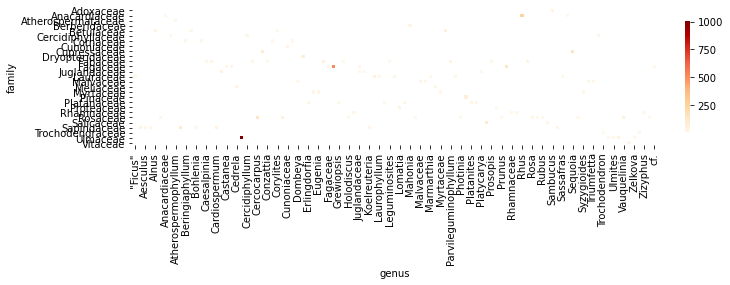

In [19]:
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_sport, 
    square=True, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

In [21]:
by_sport.shape

(27, 103)

[Text(0, 0.5, 'Adoxaceae'),
 Text(0, 1.5, 'Anacardiaceae'),
 Text(0, 2.5, 'Atherospermataceae'),
 Text(0, 3.5, 'Berberidaceae'),
 Text(0, 4.5, 'Betulaceae'),
 Text(0, 5.5, 'Cercidiphyllaceae'),
 Text(0, 6.5, 'Cornaceae'),
 Text(0, 7.5, 'Cunoniaceae'),
 Text(0, 8.5, 'Cupressaceae'),
 Text(0, 9.5, 'Dryopteridaceae'),
 Text(0, 10.5, 'Fabaceae'),
 Text(0, 11.5, 'Fagaceae'),
 Text(0, 12.5, 'Juglandaceae'),
 Text(0, 13.5, 'Lauraceae'),
 Text(0, 14.5, 'Malvaceae'),
 Text(0, 15.5, 'Meliaceae'),
 Text(0, 16.5, 'Myrtaceae'),
 Text(0, 17.5, 'Pinaceae'),
 Text(0, 18.5, 'Platanaceae'),
 Text(0, 19.5, 'Proteaceae'),
 Text(0, 20.5, 'Rhamnaceae'),
 Text(0, 21.5, 'Rosaceae'),
 Text(0, 22.5, 'Salicaceae'),
 Text(0, 23.5, 'Sapindaceae'),
 Text(0, 24.5, 'Trochodendraceae'),
 Text(0, 25.5, 'Ulmaceae'),
 Text(0, 26.5, 'Vitaceae')]

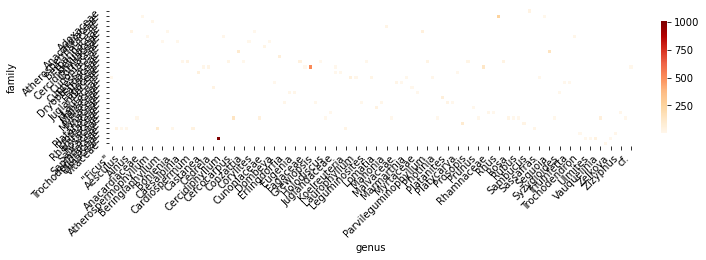

In [20]:
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_sport, 
    square=True,
    cbar_kws={'fraction' : 0.01},
    cmap='OrRd',
    linewidth=1
)

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

In [ ]:
chart = sns.catplot(
    data=data[data['Year'].isin([1980, 2008])],
    x='Sport',
    kind='count',
    palette='Set1',
    row='Year',
    aspect=3,
    height=3
)

In [36]:
import collections
count_dist = collections.Counter(data.targets)
# count_dist.update(data.targets)

import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distributions(targets: List[Any])
test = count_dist #{1:1,2:1,3:1,4:2,5:3,6:5,7:4,8:2,9:1,10:1}
# with matplotlib
plt.hist(list(test.keys()), weights=list(test.values()))

test = sorted(test.items(), key = lambda x:x[1], reverse=True)

test

sns.set_style("whitegrid")

# keys = list(test.keys())
# values = list(test.values())

keys = [i[0] for i in test]
values = [i[1] for i in test]

plt.figure(figsize=(16,12))
chart = sns.histplot(x=keys, weights=values, discrete=True)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)








# chart.set_xticklabels(
#     chart.get_xticklabels(), 
#     rotation=45, 
#     horizontalalignment='right',
#     fontweight='light',
#     fontsize='x-large'
    
# )

# None 

/media/data/conda/jrose3/envs/sequoia/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

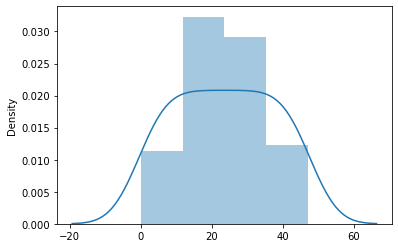

In [23]:
# with seaborn (use hist_kws to send arugments to plt.hist, used underneath)
sns.distplot(range(len(list(test.keys()))), hist_kws={"weights":list(test.values())})

In [ ]:
from pytorch_memlab import MemReporter


max_batches = 10

reporter = MemReporter()

for i, batch in enumerate(dataloader):
    print(i, len(batch), batch[0].shape)

    print('========= before backward =========')
    reporter.report()
    out = model(batch[0])
    
    loss = nn.functional.cross_entropy(out, batch[1])
    loss.backward()
    print('========= after backward =========')
    reporter.report()
    
    if i>=max_batches:
        break
    



0 3 torch.Size([64, 3, 512, 512])
========= before backward =========
Element type                                            Size  Used MEM
-------------------------------------------------------------------------------
Storage on cpu
Tensor0                                    (64, 3, 512, 512)   192.00M
Tensor1                                                (64,)   512.00B
Tensor2                                                (64,)   512.00B
Tensor3                                                (64,)   512.00B
Parameter4                                     (64, 3, 7, 7)    37.00K
Parameter5                                             (64,)   512.00B
Parameter6                                             (64,)   512.00B
Parameter7                                    (64, 64, 3, 3)   144.00K
Parameter8                                             (64,)   512.00B
Parameter9                                             (64,)   512.00B
Tensor10                                              

In [ ]:
reporter = MemReporter(model)


print('========= before loop =========')
reporter.report()
for batch in data[]
out.backward()
print('========= after backward =========')
reporter.report()
###################################################
import torch
from pytorch_memlab import MemReporter

lstm = torch.nn.LSTM(1024, 1024).cuda()
reporter = MemReporter(lstm)
reporter.report(verbose=True)
inp = torch.Tensor(10, 10, 1024).cuda()
out, _ = lstm(inp)
out.mean().backward()
reporter.report(verbose=True)





with torch.autograd.profiler.profile(use_cuda=True) as prof:
# with torch.autograd.profiler.profile() as prof:
    print('starting')
    inputs = torch.randn(5,3,224,224, device='cuda')
    print('half way')
    outputs = inputs + torch.randn(5,3,224,224, device='cuda')
    print('ending')
    
# print(prof)
print(prof.key_averages().table(sort_by="self_cpu_time_total"))

In [15]:
# from pytorch_memlab import MemReporter
# linear = torch.nn.Linear(1024, 1024).cuda()
# linear2 = torch.nn.Linear(1024, 1024).cuda()


# def inner():
#     torch.nn.Linear(100, 100).cuda()

# def outer():
#     linear = torch.nn.Linear(100, 100).cuda()
#     linear2 = torch.nn.Linear(100, 100).cuda()
#     inner()
# reporter = MemReporter()
# reporter.report()

linear = torch.nn.Linear(1024, 1024).cuda()
inp = torch.Tensor(512, 1024).cuda()
# pass in a model to automatically infer the tensor names
reporter = MemReporter(linear)
out = linear(inp).mean()
print('========= before backward =========')
reporter.report()
out.backward()
print('========= after backward =========')
reporter.report()
###################################################
import torch
from pytorch_memlab import MemReporter

lstm = torch.nn.LSTM(1024, 1024).cuda()
reporter = MemReporter(lstm)
reporter.report(verbose=True)
inp = torch.Tensor(10, 10, 1024).cuda()
out, _ = lstm(inp)
out.mean().backward()
reporter.report(verbose=True)

# import torch
# from pytorch_memlab import LineProfiler

# def inner():
#     torch.nn.Linear(100, 100).cuda()

# def outer():
#     linear = torch.nn.Linear(100, 100).cuda()
#     linear2 = torch.nn.Linear(100, 100).cuda()
#     inner()

# with LineProfiler(outer, inner) as prof:
#     outer()

In [10]:
%load_ext pytorch_memlab

'1.1.4'

In [8]:
prof.print_stats()

dir(prof)
# type(prof)

prof.display()

In [2]:
with torch.autograd.profiler.profile(use_cuda=True) as prof:
# with torch.autograd.profiler.profile() as prof:
    print('starting')
    inputs = torch.randn(5,3,224,224, device='cuda')
    print('half way')
    outputs = inputs + torch.randn(5,3,224,224, device='cuda')
    print('ending')
    
# print(prof)
print(prof.key_averages().table(sort_by="self_cpu_time_total"))

# if i % 1000 == 0:
#     print("Iteration: {}, memory: {}".format(i, psutil.virtual_memory()))

import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

model = models.resnet18()
inputs = torch.randn(5, 3, 224, 224)

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(inputs)

print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [ ]:
# pl.profiler.PyTorchProfiler(dirpath=None,
#                             filename=None,
#                             group_by_input_shapes=False,
#                             emit_nvtx=False,
#                             export_to_chrome=True,
#                             row_limit=20,
#                             sort_by_key=None,
#                             record_functions=None,
#                             record_module_names=True,
#                             profiled_functions=None,
#                             output_filename=None, 
#                             **profiler_kwargs)

In [8]:
# idx = [0,1,2,3,4]
# idx = 10
# data.display_grid(idx, repeat_n=5)
data.display_grid(idx, repeat_n=2)

In [10]:
%%time
self=data
indices=10
repeat_n=5
from itertools import repeat, chain
from more_itertools import collapse
import random
indices = random.sample(range(self.num_samples), indices)
idx = collapse((repeat(i,repeat_n) for i in indices))

# print([i for i in idx])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 87 µs


In [4]:
# self = data
# indices = idx

# if isinstance(indices, int):
#     indices = random.sample(range(self.num_samples), indices)
# indices = list(indices)
# images = [self[idx][0] for idx in indices]
# labels = [self.classes[self[idx][1]] for idx in indices]
# labels

Showing 32 images of 50:


<ipython-input-11-3f53e46756c6>:3: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


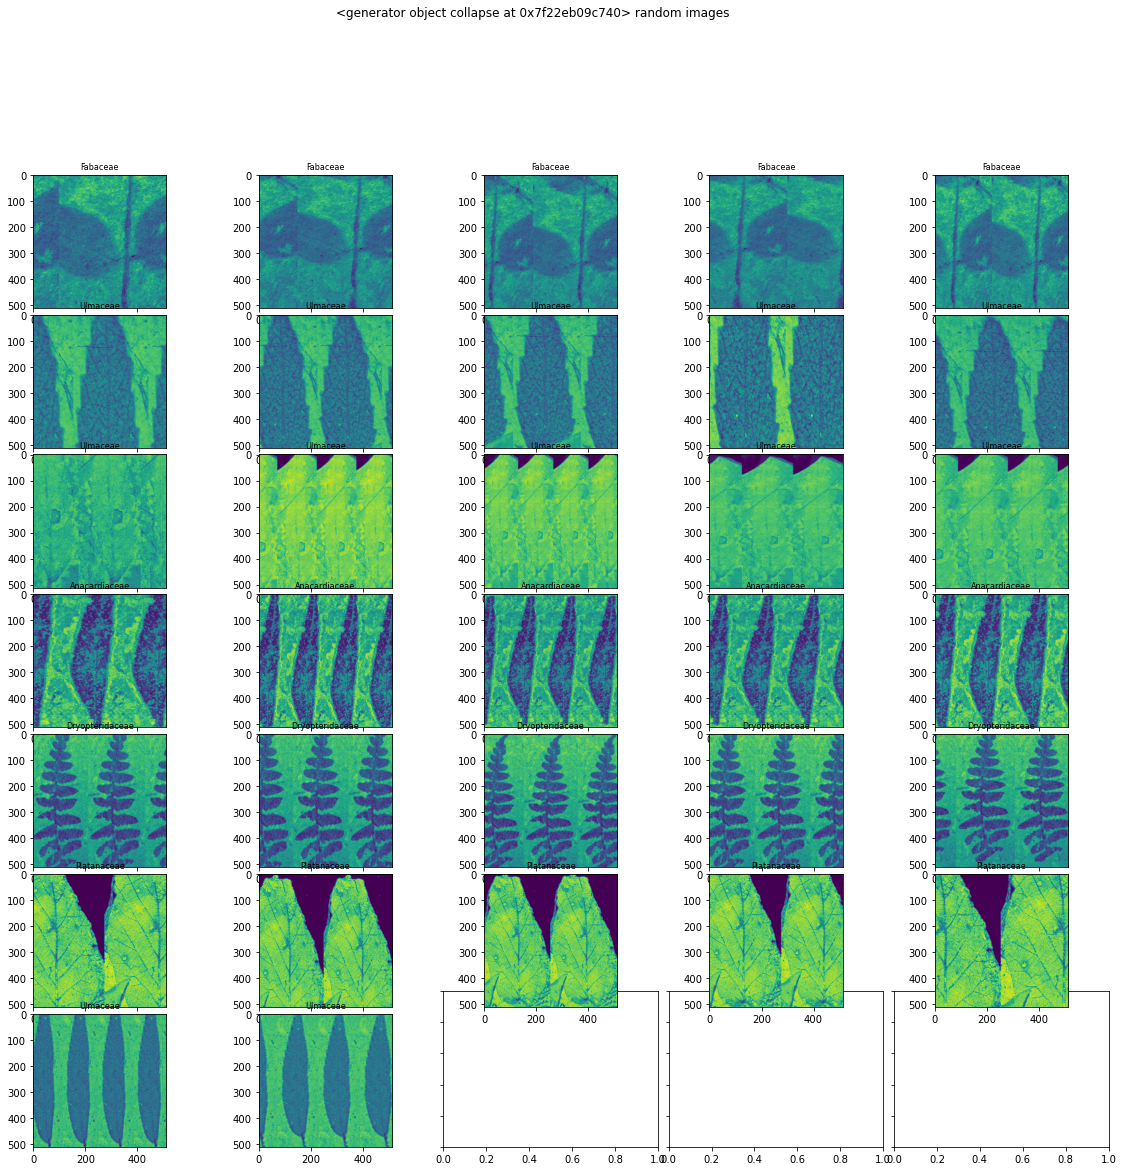

In [11]:
data.display_grid(idx)
plt.suptitle(f"{idx} random images")
plt.tight_layout()

In [6]:
# import matplotlib.pyplot as plt
# from PIL.Image import Image as PilImage
# import textwrap, os

# def display_images(
#     images: [PilImage], 
#     columns=5, max_images=15,
#     width=20, height=8,    
#     label_wrap_length=50, 
#     label_font_size=8):

#     if not images:
#         print("No images to display.")
#         return 

#     if len(images) > max_images:
#         print(f"Showing {max_images} images of {len(images)}:")
#         images=images[0:max_images]

#     rows = int(len(images)/columns)
        
#     height = max(height, rows * height)
#     plt.figure(figsize=(width, height))
#     for i, image in enumerate(images):

#         plt.subplot(rows + 1, columns, i + 1)
#         plt.imshow(image)

#         if hasattr(image, 'filename'):
#             title=image.filename
#             if title.endswith("/"): title = title[0:-1]
#             title=os.path.basename(title)
#             title=textwrap.wrap(title, label_wrap_length)
#             title="\n".join(title)
#             plt.title(title, fontsize=label_font_size); 

In [44]:
data[5][0]

import random
num_display = 12

indices = random.sample(range(data.num_samples), num_display)

indices

# indices = range(0,4)

display_images(
    images = [data[idx][0] for idx in indices],
    columns=5, max_images=15,
    width=20, height=8,    
    label_wrap_length=50, 
    label_font_size=8)

In [ ]:
#     def parse_item(self, index: int):
#         path = self.files[index]
#         family, genus, species, collection, catalog_number = path.stem.split("_", maxsplit=4)
#         item = {"path":path,
#                 "target":None,
#                 "family":family,
#                 "genus":genus,
#                 "species":species,
#                 "collection":collection,
#                 "catalog_number":catalog_number}
#         item["target"] = item[self.class_type]

## Previous Fossil class def code, now relocated to fossil.py

In [ ]:
from more_itertools import flatten
from dataclasses import dataclass

In [23]:
available_datasets = {
    "Wilf_Fossil_512": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Wilf_Fossil",
    "Wilf_Fossil_1024": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Wilf_Fossil",
    "Wilf_Fossil_1536": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Wilf_Fossil",
    "Wilf_Fossil_2048": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Wilf_Fossil",
    
    "Florissant_Fossil_512": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Florissant_Fossil",
    "Florissant_Fossil_1024": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Florissant_Fossil",
    "Florissant_Fossil_1536": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Florissant_Fossil",
    "Florissant_Fossil_2048": "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Florissant_Fossil"
}

available_datasets["Fossil_512"] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Wilf_Fossil",
                                    "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_512/Florissant_Fossil"]
available_datasets["Fossil_1024"] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Wilf_Fossil",
                                     "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1024/Florissant_Fossil"]
available_datasets["Fossil_1536"] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Wilf_Fossil",
                                     "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_1536/Florissant_Fossil"]
available_datasets["Fossil_2048"] = ["/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Wilf_Fossil",
                                     "/media/data_cifs/projects/prj_fossils/data/processed_data/leavesdb-v0_3/Fossil/ccrop_2048/Florissant_Fossil"]

fossil_collections = {"Florissant":"florissant_fossil",
                      "Wilf":"wilf_fossil"}

@dataclass
class DatasetConfig:
    name: str
    dataset: str=None
    collection: str=None
    resolution: int=None
        
    num_files: Optional[int]=None
    num_classes: Optional[int]=None
    class_type: str="family"
    path_schema: str = "{family}_{genus}_{species}_{collection}_{catalog_number}"
                
        
    def __init__(self, name: str, **kwargs):
        self.name = name
        parts = self.name.split("_")
        self.resolution = int(parts[-1])
        if len(parts)==3:
            self.dataset = parts[1]
            self.collection = "_".join(parts[:2])
        elif len(parts)==2:    
            self.dataset = parts[0]
            self.collection = ["_".join([c, self.dataset]) for c in fossil_collections.keys()]
            
        self.__dict__.update(kwargs)

    def __repr__(self):
        disp = f"""<{str(type(self)).strip("'>").split('.')[1]}>:"""
        
        disp += "\nFields:\n"
        for k in self.__dataclass_fields__.keys():
            disp += f"    {k}: {getattr(self,k)}\n"
        return disp
    

DatasetConfig("Fossil_512")

class FossilDataset(torchdata.datasets.Files): #ImageDataset):
    
#     loader: Callable = Image.open
    transform = None
    target_transform = None
    
    class_type: str="family"
    totensor: Callable = torchvision.transforms.ToTensor()
    def __init__(self,
                 files: List[Path],
                 return_items: List[str] = ["image","target","path"],
                 image_return_type: str = "tensor",
                 *args, **kwargs):
        super().__init__(files=files, *args, **kwargs)
        
        self.name = kwargs.get("name","")
        self.return_items = return_items
        self.image_return_type = image_return_type
        
        self.samples = [self.parse_item(idx) for idx in range((len(self)))]
        self.targets = [sample[1] for sample in self.samples]
        self._imgs = None
        self.classes = sorted(set(self.targets))
        self.class2idx = {name:idx for idx, name in enumerate(self.classes)}
        
        self.config = DatasetConfig(self.name,
                                    class_type=self.class_type,
                                    num_files=len(self.files),
                                    num_classes=len(self.classes)
                                   )

    def getitem(self, index: int):
        path, family, genus, species, collection, catalog_number = self.samples[index]
        img = Image.open(path)
        return img, family, path

#     @property
#     def transform(self) -> Callable:#, img: PIL.Image):
#         _transforms = []
#         if self.image_return_type == "tensor":
#             _transforms.append(self.totensor)
#         return lambda x: x
        
    def __getitem__(self, index: int):
        
        img, family, path = self.getitem(index)
        target = self.class2idx[family]
        
        if self.image_return_type == "tensor":
            img = self.totensor(img)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, path
    
    
    def parse_item(self, index: int):
        path = self.files[index]
        family, genus, species, collection, catalog_number = path.stem.split("_", maxsplit=4)
        return path, family, genus, species, collection, catalog_number
    
    def __repr__(self):
        return self.config.__repr__()
        

    @classmethod
    def create_dataset(cls, name: str) -> "ImageDataset":
        dataset_dirs = available_datasets[name]
        if isinstance(available_datasets[name], str):
            dataset_dirs = [available_datasets[name]]
        assert isinstance(dataset_dirs, list)
        file_list = list(flatten(
                            [torchdata.datasets.Files.from_folder(Path(root),
                                                                  regex="*/*.jpg").files
                             for root in dataset_dirs]
                                                    ))
        data = FossilDataset(file_list,
                             name=name)

        return data #.map(lambda x: (torchvision.transforms.ToTensor()(x[0]), x[1]))
    
    
#     @classmethod
#     def create_dataset(cls, name: str) -> "ImageDataset":
#         dataset_dirs = available_datasets[name]
#         if isinstance(available_datasets[name], list):
#             file_list = list(flatten(
#                                 [torchdata.datasets.Files.from_folder(Path(root),
#                                                         regex="*/*.jpg").files
#                                for root in available_datasets[name]]
#                                                             ))
            
#         elif isinstance(available_datasets[name], str):
#             file_list = torchdata.datasets.Files.from_folder(Path(available_datasets[name]),
#                                                              regex="*/*.jpg").files

#         data = FossilDataset(file_list,
#                                  name=name)

#         return data.map(torchvision.transforms.ToTensor())

fossil_data = FossilDataset.create_dataset(name="Fossil_1024")
fossil_data

# fossil_data = FossilDataset.create_dataset(name="Florissant_Fossil_1024")
# fossil_data

# fossil_data = FossilDataset.create_dataset(name="Wilf_Fossil_1024")
# fossil_data

### Future todo: Separate subclass of simpler Leaves/Fossil Dataset class to allow for more customization of return signatures (allowing dict records instead of tuple, multiple labels per sample)

In [156]:
class MultiLabelFossilDataset(FossilDataset): #ImageDataset):
    
    loader: Callable = Image.open
    transform = torchvision.transforms.ToTensor()
    target_transform = None
    
    class_type: str="family"
    
    def __init__(self,
                 files: List[Path],
                 return_items: List[str,str] = ["image","target","path"],
                 *args, **kwargs):
        super().__init__(files=files, *args, **kwargs)
        
        self.name = kwargs.get("name","")
        self.return_items = return_items
        
        self.samples = [self.parse_item(idx) for idx in range((len(self)))]            
        self.targets = [sample[1] for sample in self.samples]
        self.classes = sorted(set(self.targets))
        self.class2idx = {name:idx for idx, name in enumerate(self.classes)}
        
        self.config = DatasetConfig(self.name,
                                    class_type=self.class_type,
                                    num_files=len(self.files),
                                    num_classes=len(self.classes)
                                    )
        
        
    
        
    def get_item(self, index: int):
        item = self.samples[index]
        img = self.loader(item["path"])
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return self.get_item((img, target, path))
    
        return Image.open(item[0]), self.class2idx[item[1]]

    
        
    def __getitem__(self, index: int):
        item = self.samples[index]
        
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return self.get_item((img, target, path))
#         return Image.open(item[0]), self.class2idx[item[1]]
    
    def parse_item(self, index: int):
        path = self.files[index]
        family, genus, species, collection, catalog_number = path.stem.split("_", maxsplit=4)
        item = {"path":path,
                "target":None,
                "family":family,
                "genus":genus,
                "species":species,
                "collection":collection,
                "catalog_number":catalog_number}
        item["target"] = item[self.class_type]
#         return path, family, genus, species, collection, catalog_number
    
    def __repr__(self):
        return self.config.__repr__()
        
#     @property
#     def config(self):
#         return DatasetConfig(self.name,
#                              num_files=len(self.files),
#                              num_classes=len(self.classes)
#                             )
    @classmethod
    def create_dataset(cls, name: str) -> "ImageDataset":
        dataset_dirs = available_datasets[name]
        if isinstance(available_datasets[name], str):
            dataset_dirs = [available_datasets[name]]
        assert isinstance(dataset_dirs, list)
        file_list = list(flatten(
                            [torchdata.datasets.Files.from_folder(Path(root),
                                                                  regex="*/*.jpg").files
                             for root in dataset_dirs]
                                                    ))
        data = FossilDataset(file_list,
                             name=name)

        return data.map(lambda x: (torchvision.transforms.ToTensor()(x[0]), x[1]))
    
    
#     @classmethod
#     def create_dataset(cls, name: str) -> "ImageDataset":
#         dataset_dirs = available_datasets[name]
#         if isinstance(available_datasets[name], list):
#             file_list = list(flatten(
#                                 [torchdata.datasets.Files.from_folder(Path(root),
#                                                         regex="*/*.jpg").files
#                                for root in available_datasets[name]]
#                                                             ))
            
#         elif isinstance(available_datasets[name], str):
#             file_list = torchdata.datasets.Files.from_folder(Path(available_datasets[name]),
#                                                              regex="*/*.jpg").files

#         data = FossilDataset(file_list,
#                                  name=name)

#         return data.map(torchvision.transforms.ToTensor())

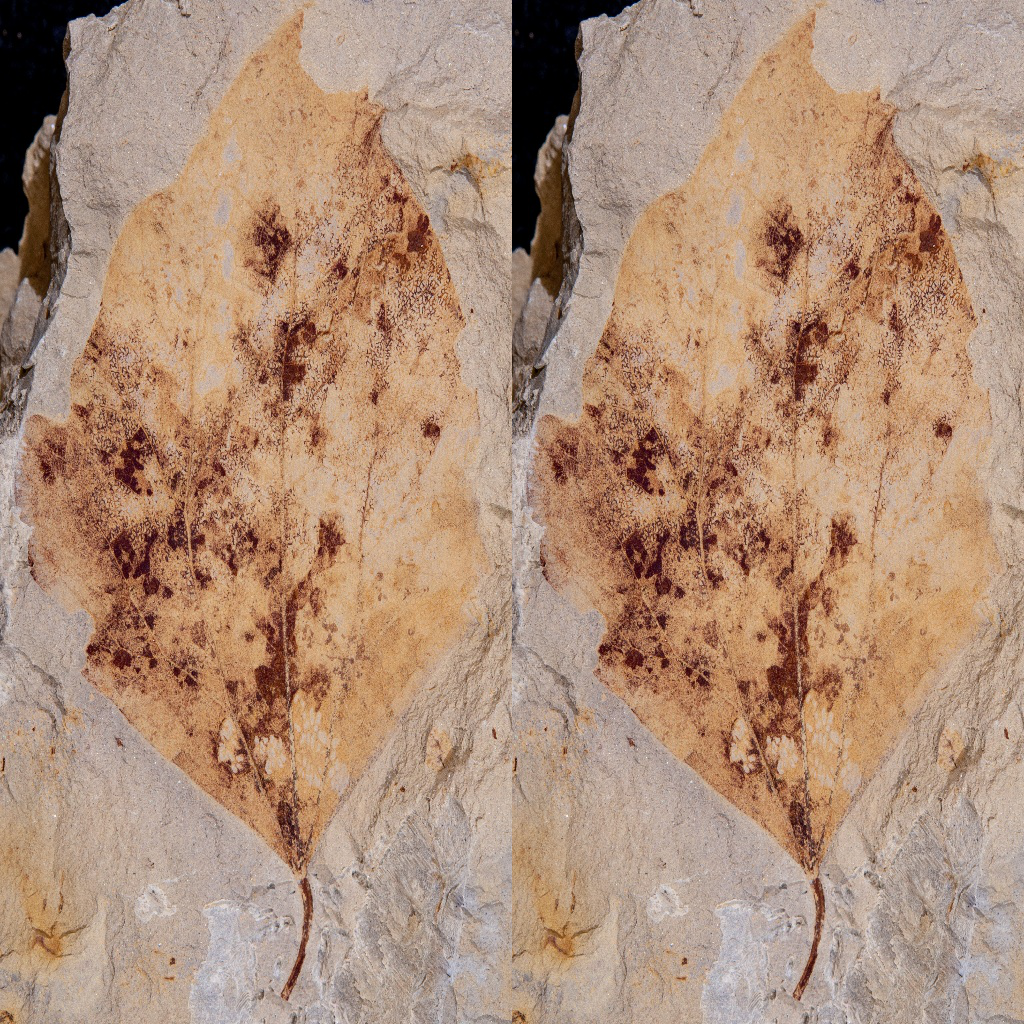

In [149]:
Image.open(fossil_data.samples[0][0])

In [146]:
fossil_data.class2idx

{'Adoxaceae': 0,
 'Akaniaceae': 1,
 'Altingiaceae': 2,
 'Anacardiaceae': 3,
 'Apocynaceae': 4,
 'Araceae': 5,
 'Arecaceae': 6,
 'Atherospermataceae': 7,
 'Berberidaceae': 8,
 'Betulaceae': 9,
 'Cannabaceae': 10,
 'Cercidiphyllaceae': 11,
 'Cornaceae': 12,
 'Cunoniaceae': 13,
 'Cupressaceae': 14,
 'Dryopteridaceae': 15,
 'Ericaceae': 16,
 'Euphorbiaceae': 17,
 'Fabaceae': 18,
 'Fagaceae': 19,
 'Grossulariaceae': 20,
 'Hamamelidaceae': 21,
 'Hydrangeaceae': 22,
 'Iteaceae': 23,
 'Juglandaceae': 24,
 'Lauraceae': 25,
 'Magnoliaceae': 26,
 'Malvaceae': 27,
 'Meliaceae': 28,
 'Menispermaceae': 29,
 'Monimiaceae': 30,
 'Myricaceae': 31,
 'Myrtaceae': 32,
 'Oleaceae': 33,
 'Pinaceae': 34,
 'Platanaceae': 35,
 'Proteaceae': 36,
 'Rhamnaceae': 37,
 'Rhipogonaceae': 38,
 'Rosaceae': 39,
 'Salicaceae': 40,
 'Sapindaceae': 41,
 'Taxaceae': 42,
 'Theaceae': 43,
 'Trochodendraceae': 44,
 'Ulmaceae': 45,
 'Vitaceae': 46,
 'Zingiberaceae': 47}

In [137]:
# class ImageDataset(torchdata.datasets.Files):
    
#     def __getitem__(self, index):
#         return Image.open(self.files[index])
    
# #     def __repr__(self):
# #         return f"""{self.kwargs['name']}"""
# #         return f"""ImageDataset: {self.kwargs['name']}"""

#     def __init__(self, files: List[Path], *args, **kwargs):
#         super().__init__(files=files, *args, **kwargs)
        
# #         self.name = kwargs.get("name","")
# #         self.cfg = DatasetConfig(self.name)


#     @classmethod
#     def create_dataset(cls, name: str) -> "ImageDataset":
#         dataset_dirs = available_datasets[name]

#         if isinstance(available_datasets[name], str):
#             data = ImageDataset.from_folder(Path(available_datasets[name]),
#                                             regex="*/*.jpg",
#                                             name=name)
#         return data.map(torchvision.transforms.ToTensor())    

In [2]:
from IPython.core.debugger import set_trace

import os
import types
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
import pytorch_lightning as pl
from torchvision import models
import torchvision
import torch
import timm
from rich import print
import matplotlib.pyplot as plt
from contrastive_learning.data.pytorch.pnas import PNASLightningDataModule
from contrastive_learning.data.pytorch.extant import ExtantLightningDataModule
from contrastive_learning.data.pytorch.common import DataStageError, LeavesLightningDataModule

from lightning_hydra_classifiers.callbacks.wandb_callbacks import WatchModelWithWandb, LogPerClassMetricsToWandb, WandbClassificationCallback # LogConfusionMatrixToWandb
from lightning_hydra_classifiers.models.resnet import ResNet, get_scalar_metrics
import lightning_hydra_classifiers
from torch import nn
import inspect

import wandb
pl.trainer.seed_everything(seed=9)

    
# class Config:
#     pass


# config = Config()

# # config.model_name = 'resnet50'
# # config.dataset_name = 'PNAS_family_100_512'
# config.dataset_name = '(Extant-PNAS)_family_10_512'
# config.normalize = True
# config.num_workers = 4
# config.batch_size = 16

# config = Box({
#     "dataset":{
#         namef"PNAS_{label_type}_{pnas_threshold}"
#     }
    
# })

########################################
# if 'Extant' in config.dataset_name:
#     datamodule = ExtantLightningDataModule(name=config.dataset_name, batch_size=config.batch_size, debug=False, normalize=config.normalize, num_workers=config.num_workers)
# elif 'PNAS' in config.dataset_name:
#     datamodule = PNASLightningDataModule(name=config.dataset_name, batch_size=config.batch_size, debug=False, normalize=config.normalize, num_workers=config.num_workers)#, normalize=False)#True)
# datamodule.setup('fit')
# ########################################
# num_classes = len(datamodule.classes)
# config.num_classes = num_classes

Global seed set to 9


9

In [7]:
from box import Box
import os

os.environ['WANDB_CACHE_DIR'] = "/media/data/jacob/wandb_cache"
class_type = "family"
extant_threshold = 10
pnas_threshold = 100
image_size = 512
seed = 257

config = Box({})

config.datasets = [{
                  "name": f"PNAS_{class_type}_{pnas_threshold}_{image_size}",
                  "batch_size":32,
                  "val_split":None, # TODO specify split explicitly in wandb report
                  "num_workers":4,
                  "image_size":image_size,
                  "channels":3,
                  "class_type":class_type,
                  "debug":False,
                  "normalize":True,
                  "seed":seed,
                  "dataset_dir":None,
                  "predict_on_split":"val",
                  },
    {
                  "name":f"Extant_{class_type}_{extant_threshold}_{image_size}",  # f"PNAS_{label_type}_{pnas_threshold}_{image_size}"
                  "batch_size":32,
                  "val_split":None, # TODO specify split explicitly in wandb report
                  "num_workers":4,
                  "image_size":image_size,
                  "channels":3,
                  "class_type":class_type,
                  "debug":False,
                  "normalize":True,
                  "seed":seed,
                  "dataset_dir":None,
                  "predict_on_split":"val",
                  }]



config.wandb = {
                "init":
                       {
                        "entity":"jrose",
                        "project":"image_classification_datasets",
                        "job_type":'create-dataset',
                        "group":None,
                        "run_dir":os.environ['WANDB_CACHE_DIR'],
                        "tags":[d.name for d in config.datasets]
                       },
                "artifacts":
                        {
                        "root_dir":None
                        },
                "input_artifacts":
                       [
                           {
                            "entity":"jrose",
                            "project":"image_classification_datasets",
                            "name": config.datasets[0].name,
                            "version": "v6",
                            "type": "raw_data",
                            "root_dir":None,
                            "uri":None
                           }
                       ]
}

i = 0

config.wandb.artifacts.root_dir = os.path.join(config.wandb.init.run_dir,
                                               "artifacts")

config.wandb.input_artifacts[i].uri = "/".join([config.wandb.input_artifacts[i].entity,
                                                config.wandb.input_artifacts[i].project,
                                                config.wandb.input_artifacts[i].name]) \
                                           + f':{config.wandb.input_artifacts[i].version}'


config.wandb.input_artifacts[i].root_dir = os.path.join(config.wandb.artifacts.root_dir,
                                                        "datasets",
                                                         config.wandb.input_artifacts[i].name \
                                                         + f':{config.wandb.input_artifacts[i].version}'
                                                        )


# def fetch_datamodule_from_dataset_artifact(config: Box, run_or_api=None) -> LeavesLightningDataModule:
#     run = run_or_api or wandb.Api()
#     artifact = run.use_artifact(config.wandb.input_artifact.uri,
#                                 type=config.wandb.input_artifact.type)
#     dataset_artifact_dir = artifact.download(root=config.wandb.input_artifact.root_dir)


#     datamodule = get_datamodule(config.dataset)
#     datamodule.setup('fit')
#     datamodule.setup('test')
#     ########################
#     config.model.num_classes = config.dataset.num_classes

def fetch_datamodule_from_dataset_artifact(config: Box, run_or_api=None) -> LeavesLightningDataModule:
    run = run_or_api or wandb.Api()
    artifact = run.use_artifact(config.wandb.input_artifact.uri,
                                type=config.wandb.input_artifact.type)
    dataset_artifact_dir = artifact.download(root=config.wandb.input_artifact.root_dir)


    datamodule = get_datamodule(config.dataset)
    datamodule.setup('fit')
    datamodule.setup('test')
    ########################
    config.model.num_classes = config.dataset.num_classes


In [56]:
import pandas as pd
import numpy as np
from PIL import Image, ImageStat
import seaborn_image as isns
import scipy

def image_stat(img: np.ndarray):
    if img.ndim==3:
        h, w, c = img.shape
    else:
        h, w, c = (*img.shape, 1)
    return {
        "min":np.min(img),
        "max":np.max(img),
        "var":np.var(img),
        "mean":np.mean(img),
        "mode":scipy.stats.mode(img,axis=None),
        "height":h,
        "width":w,
        "channels":c,
        "num_pixels":h*w*c
    }


def load_and_analyze_image(image_path: str):
    img = np.array(Image.open(image_path))
    return img, image_stat(img)

# def load_analyze_and_save_annotated_image(image_path: str):
#     img, stats = load_and_analyze_image(image_path)
#     return img, image_stat(img)




def fig2data ( fig ):
    """
    @brief Convert a Matplotlib figure to a 4D numpy array with RGBA channels and return it
    @param fig a matplotlib figure
    @return a numpy 3D array of RGBA values
    """
    # draw the renderer
    fig.canvas.draw()
 
    # Get the RGBA buffer from the figure
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring(fig.canvas.tostring_argb(), dtype=np.uint8)
    buf.shape = ( w, h, 4 )
 
    # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
    buf = np.roll( buf, 3, axis = 2 )
    return buf

 
def fig2img ( fig ):
    """
    @brief Convert a Matplotlib figure to a PIL Image in RGBA format and return it
    @param fig a matplotlib figure
    @return a Python Imaging Library ( PIL ) image
    """
    # put the figure pixmap into a numpy array
    buf = fig2data(fig)
    w, h, d = buf.shape
    return Image.frombytes("RGBA", (w, h), buf.tostring())

# f = isns.imghist(img_array,
#                  describe=True)
# results = fig2img(f)

In [5]:
config.wandb.input_artifacts[0].uri

'jrose/image_classification_datasets/PNAS_family_100_512:v0'

In [8]:
import wandb
api = wandb.Api()
artifact = api.artifact(config.wandb.input_artifacts[0].uri)

In [57]:
artifact.data

AttributeError: 'Artifact' object has no attribute 'data'

In [25]:
# dir(artifact)
# dir(artifact.manifest)
# artifact.manifest.entries

In [27]:
data = artifact.get('dataset/test.table.json')

In [88]:
type(data)

wandb.data_types.Table

In [60]:
df=data.data

print(data.columns)


data_df = pd.DataFrame(data=df, columns=data.columns)

['image', 'label', 'family', 'genus', 'species', 'collection', 'catalog_number']

In [89]:
wide_samples = data_df
samples = list(data_df[['image', 'label']].itertuples())

<BarContainer object of 19 artists>

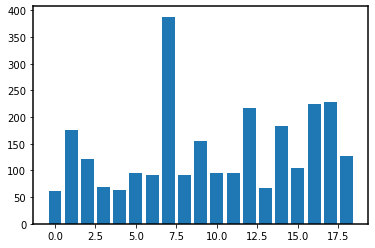

In [97]:

num_classes = len(set(wide_samples.label.values))
plt.bar(range(num_classes), wide_samples.groupby("label")["catalog_number"].count())

In [82]:
# in_mem = data_df.image.apply(lambda x: np.array(x._image))
in_mem = data_df.image.apply(lambda x: x._image)

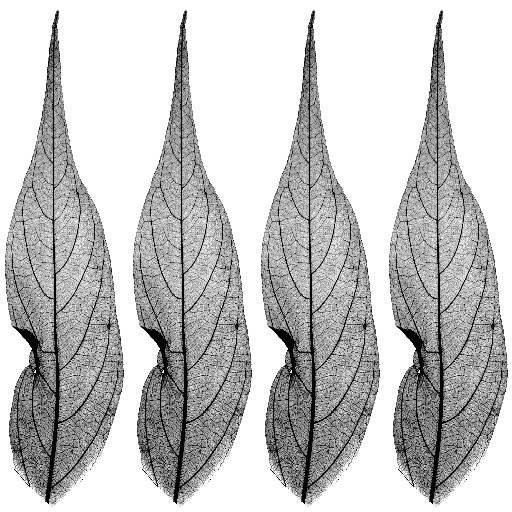

In [87]:
in_mem[199]

In [79]:
np.array(data_df.image[0]._image).shape


in_mem[0]

In [44]:


from IPython.display import display

df = data.get_column('image')

data.columns

In [19]:
dir(artifact)

downloaded_artifact = artifact.checkout(root=config.wandb.input_artifacts[0].root_dir)

In [21]:
# os.path.abspath
(downloaded_artifact)

'/media/data/jacob/wandb_cache/artifacts/datasets/PNAS_family_100_512:v6'

In [ ]:
from contrastive_learning.data.pytorch.pnas import PNASLeavesDataset
from contrastive_learning.data.pytorch.extant import ExtantLeavesDataset
# from contrastive_learning.data.pytorch.common import DataStageError
from paleoai_data.dataset_drivers import base_dataset

# Step 1. Instantiate PyTorch Datasets for each of Extant Leaves & PNAS, separately
pnas_torch = PNASLeavesDataset(name = f"PNAS_{label_type}_{pnas_threshold}",
                 split: str="train",
                 dataset_dir: Optional[str]=None,
                 return_paths: bool=False,)
extant_torch = ExtantLeavesDataset




# def create_dataset_by_name(name: str,
#                            version: str='v0.2',
#                            exclude_classes = ['notcataloged','notcatalogued', 'II. IDs, families uncertain', 'Unidentified']):
#     data_df = query_db(version=version, **{'dataset':name})
#     dataset = base_dataset.BaseDataset.from_dataframe(df=data_df, name=name, exclude_classes=exclude_classes)
#     return dataset

In [ ]:
datamodule.train_dataset[0][0].shape

In [ ]:
with wandb.init(project=WANDB_PROJECT, job_type="model_result_analysis") as run:
    
    # Retrieve the original raw dataset
    dataset_artifact = run.use_artifact("raw_data:latest")
    data_table = dataset_artifact.get("raw_examples")
    
    # Retrieve the train and test score tables
    train_artifact = run.use_artifact("train_results:latest")
    train_table = train_artifact.get("train_iou_score_table")

In [ ]:
# data = PNASLightningDataModule(batch_size=16)
# data = ExtantLightningDataModule(batch_size=16, num_workers=12)
# data.setup(stage='fit')

# data.setup(stage='test')

# data.setup(stage=None)

# try:
#     data.setup(stage='other')
#     print('success')
# except DataStageError as e:
#     print(e.with_traceback(None))

In [ ]:
data.setup(stage='fit')
train_dataloader = data.get_dataloader(stage='train')
val_dataloader = data.get_dataloader(stage='val')
data.setup(stage='test')
test_dataloader = data.get_dataloader(stage='test')

# train_dataloader
#         if stage=='train': return self.train_dataloader()
#         if stage=='val': return self.val_dataloader()
#         if stage=='test': return self.test_dataloader()


In [ ]:


# data.train_dataset.transform = None #data.default_train_transforms() #None
x, y = data.train_dataset[0]
# print(x.shape)

In [ ]:
# from PIL import ImageOps

# print(x.max(), x.min())
# plt.imshow(ImageOps.invert(x))#.permute(1,2,0))

In [ ]:
%%time
batch_idx = 0

data.show_batch('train', batch_idx=batch_idx)
# data.show_batch('train', cmap='plasma')
plt.savefig(f'ExtantLeaves v0_3 train batch {batch_idx}.png')

data.show_batch('val', batch_idx=batch_idx)
plt.savefig(f'ExtantLeaves v0_3 val batch {batch_idx}.png')

data.show_batch('test', batch_idx=batch_idx)
plt.savefig(f'ExtantLeaves v0_3 test batch {batch_idx}.png')
# data.show_batch('train', cmap='magma')
# data.show_batch('train', cmap='cividis')

In [ ]:
self = data
stage = 'test'
batch_idx = 0

x, y = self.get_batch(stage=stage, batch_idx=batch_idx)

x = x[:12,...]

batch_size = x.shape[0]

fig, ax = plt.subplots(1,1, figsize=(24,24))
grid_img = torchvision.utils.make_grid(x, nrow=int(np.ceil(np.sqrt(batch_size))))

img_min, img_max = grid_img.min(), grid_img.max()
print(img_min, img_max)

grid_img = (grid_img - img_min)/(img_max - img_min)
img_min, img_max = grid_img.min(), grid_img.max()
print(img_min, img_max)



print('before:', grid_img.shape)

if torch.argmin(torch.Tensor(grid_img.shape)) == 0:
    grid_img = grid_img.permute(1,2,0)
print('after:', grid_img.shape)

img_ax = ax.imshow(grid_img[:,:,0], cmap='viridis')#, vmin = img_min, vmax = img_max)
fig.colorbar(img_ax, ax=ax)#)#cax=ax)
plt.axis('off')
plt.suptitle(f'{stage} batch')
#         return fig, ax

help(plt.imshow)

%debug

x, y = next(iter(train_dataloader))

x.min()

plt.imshow(x[1,...].permute(1,2,0))